 <h1><center> <font color='green'>CNN  Basado en TL Inception V3 </font></center></h1> 

 <h1><center> <font color='blue'>Librerías</font></center></h1> 


In [1]:
"""Importar librerias para realizar CNN"""
import os
"""Cargar las imagenes"""
import cv2
from PIL import Image
"""Tensoflow para las redes neuronales"""
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
"""Librería para calculo numerico"""
import numpy as np
"""Libreria para graficas"""
import matplotlib.pyplot as plt
"""Importa para dividir el conjunto de datos en entrenamiento y prueba"""
from sklearn.model_selection import train_test_split
"""Librería que que ofrece metricas"""
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
"""Importa datos de señales de registro de archivos de ejecuciones
de simulación disponibles para la aplicación en tiempo real seleccionadas"""
import time
import math
import logging

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h1><center> <font color='orange'>Carga y exploración de datos</font></center></h1> 

In [23]:
"""Definición del tamaño, array de las imagenes"""
IMG_SHAPE  = 224
batch_size = 32
random_seed = 9

In [4]:
fpath = "/content/drive/MyDrive/Mineria/vocales"
categories = os.listdir(fpath)
print("Lista de categorias = ",categories,"\n\nNo. de categorias = ", len(categories))

Lista de categorias =  ['e', 'i', 'a', 'o', 'u'] 

No. de categorias =  5


In [24]:
"""Funcion para cargar las imagenes por categorias"""
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SHAPE, IMG_SHAPE))
            img_array = Image.fromarray(img, 'RGB')

            img_lst.append(np.array(img_array))

            labels.append(index)
    return img_lst, labels
"""Cargar las imagenes desde las categorias"""
images, labels = load_images_and_labels(categories)
"""Mostrar la cantidad de imagenes cargadas"""
print("Nº de imágenes cargadas = ",len(images),"\nNo. de etiquetas cargadas = ",len(labels))
print(type(images),type(labels))

Nº de imágenes cargadas =  1000 
No. de etiquetas cargadas =  1000
<class 'list'> <class 'list'>


In [25]:
"""Variables para ver el array de las imagenes y los label"""
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (1000, 224, 224, 3) 
Labels shape =  (1000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


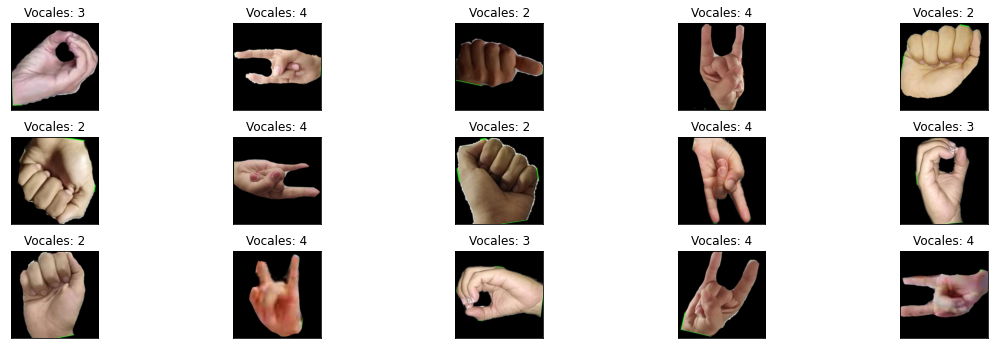

In [26]:
"""Función para visualizar imagenes aleatorias """
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(15):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(5 , 5 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        """Array de las vocales"""
        plt.title('Vocales: {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
"""Mostrar imagenes con sus labels"""
display_rand_images(images, labels)

<h1>Definición del conjunto de datos para pruebas y entrenamiento

In [27]:
"""Primero se reorganizan los datos"""

"""Obtener números igualmente espaciados en un rango dado"""
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

"""Mezclar todos los valores igualmente espaciados en la lista 'n'"""
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238

In [28]:
"""El segundo paso es la mezcla de datos"""

"""imágenes aleatorias y datos de etiquetas correspondientes en ambas listas"""
images = images[n]
labels = labels[n]

print("Forma de las imágenes después de la mezcla = ",images.shape,"\nForma de las etiquetas después de mezclar= ",labels.shape)

Forma de las imágenes después de la mezcla =  (1000, 224, 224, 3) 
Forma de las etiquetas después de mezclar=  (1000,)


### Normalización

In [29]:
"""Normalizacion de los datos, segun su tipo: float, int"""
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Forma de las imágenes después de la normalización = ",images.shape)

Forma de las imágenes después de la normalización =  (1000, 224, 224, 3)


### Training and Testing

In [30]:
'''Se divide el conjunto de datos en 80% para entrenamiento y 20% para prueba'''
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

x_val = x_train[:58]
y_val = y_train[:58]
x_train = x_train[58:]
y_train = y_train[58:]

"""Mostrar los array en cada parte del entrenamiento y la prueba"""

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

x_train shape =  (742, 224, 224, 3)
y_train shape =  (742,)

x_test shape =  (200, 224, 224, 3)
y_test shape =  (200,)

x_val shape =  (58, 224, 224, 3)
y_val shape =  (58,)


In [31]:
"""Estructura One-hot-encode"""
y_train = to_categorical(y_train, 5)
y_test = to_categorical(y_test, 5)
y_val = to_categorical(y_val, 5)


 <h1><center> <font color='purple'>Implementación del modelo CNN Basado en TL Inception V3</font></center></h1> 

In [32]:
"""Función para el pre-entrenamiento del modelo, con InceptionV3"""
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=x_train[0].shape, include_top=False, weights="imagenet")


In [33]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False


input_2
conv2d_94
batch_normalization_96
activation_94
conv2d_95
batch_normalization_97
activation_95
conv2d_96
batch_normalization_98
activation_96
max_pooling2d_4
conv2d_97
batch_normalization_99
activation_97
conv2d_98
batch_normalization_100
activation_98
max_pooling2d_5
conv2d_102
batch_normalization_104
activation_102
conv2d_100
conv2d_103
batch_normalization_102
batch_normalization_105
activation_100
activation_103
average_pooling2d_9
conv2d_99
conv2d_101
conv2d_104
conv2d_105
batch_normalization_101
batch_normalization_103
batch_normalization_106
batch_normalization_107
activation_99
activation_101
activation_104
activation_105
mixed0
conv2d_109
batch_normalization_111
activation_109
conv2d_107
conv2d_110
batch_normalization_109
batch_normalization_112
activation_107
activation_110
average_pooling2d_10
conv2d_106
conv2d_108
conv2d_111
conv2d_112
batch_normalization_108
batch_normalization_110
batch_normalization_113
batch_normalization_114
activation_106
activation_108
activati

## GridSearchCV

In [15]:
from sklearn.model_selection import GridSearchCV,KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
def create_model(dropout_rate,units ):
  
  last_layer = pre_trained_model.get_layer('mixed10')
  last_output = last_layer.output
  x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
  x = tf.keras.layers.GlobalMaxPooling2D()(last_output)


  x = tf.keras.layers.Dense(units= units, activation='relu')(x)
  x = tf.keras.layers.Dense(units= units, activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout_rate)(x)

  x = tf.keras.layers.Dense(units= units, activation='relu')(x)
  x = tf.keras.layers.Dense(units= units, activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout_rate)(x)


  x = tf.keras.layers.Dense(5, activation='softmax')(x)
  model_GridSearchCV = tf.keras.Model(pre_trained_model.input, x)
  """Configuracion para compilar el modelo, tambien se optimiza"""
  model_GridSearchCV.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])
  return model_GridSearchCV



model_GridSearchCV = KerasClassifier(build_fn = create_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [17]:
batch_size = [32,40]
epochs = [10]
#learning_rate = [0.001,0.01,0.1]
dropout_rate = [0.1,0.2,0.3,0.4,0.5]
#activation_function = ['softmax','relu','tanh','linear']
#init = ['uniform']
units = [512,1004,350,784]
#neuron1 = [128,256]
#neuron2 = [128,256]


param_grids = dict(batch_size = batch_size,epochs = epochs,dropout_rate = dropout_rate,
                   units = units)



grid = GridSearchCV(estimator = model_GridSearchCV,param_grid = param_grids,cv = 2,verbose = 1)
grid_result = grid.fit(x_train, y_train)

Fitting 2 folds for each of 40 candidates, totalling 80 fits
Epoch 1/10
12/12 [==============================] - 20s 399ms/step - loss: 1.0784 - acc: 0.5849
Epoch 2/10
12/12 [==============================] - 2s 203ms/step - loss: 0.4060 - acc: 0.8706
Epoch 3/10
12/12 [==============================] - 2s 203ms/step - loss: 0.1671 - acc: 0.9380
Epoch 4/10
12/12 [==============================] - 2s 203ms/step - loss: 0.0879 - acc: 0.9650
Epoch 5/10
12/12 [==============================] - 2s 203ms/step - loss: 0.1595 - acc: 0.9434
Epoch 6/10
12/12 [==============================] - 2s 205ms/step - loss: 0.1473 - acc: 0.9515
Epoch 7/10
12/12 [==============================] - 2s 207ms/step - loss: 0.0909 - acc: 0.9623
Epoch 8/10
12/12 [==============================] - 2s 206ms/step - loss: 0.0589 - acc: 0.9811
Epoch 9/10
12/12 [==============================] - 2s 206ms/step - loss: 0.0525 - acc: 0.9757
Epoch 10/10
12/12 [==============================] - 4s 206ms/step - loss: 5.8353 -

In [18]:
best_params=grid.best_params_
accuracy=grid.best_score_

In [19]:
print(best_params)

{'batch_size': 32, 'dropout_rate': 0.4, 'epochs': 10, 'units': 784}


In [20]:
print(accuracy)

0.7964959740638733


## modelo


In [34]:
last_layer = pre_trained_model.get_layer('mixed10')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)


x = tf.keras.layers.Dense(units= 784, activation='relu')(x)
x = tf.keras.layers.Dense(units= 784, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Dense(units= 784, activation='relu')(x)
x = tf.keras.layers.Dense(units= 784, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)


x = tf.keras.layers.Dense(5, activation='softmax')(x)
model = tf.keras.Model(pre_trained_model.input, x)

In [35]:
"""Configuracion para compilar el modelo, tambien se optimiza"""
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [36]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_96 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

## Entrenamiento del Modelo

In [37]:
steps_per_epoch = (x_train.shape[0]//batch_size)
validation_steps = (x_val.shape[0] // batch_size)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [38]:
"""Visualizar el array de los datos de entrenamiento"""
x_train.shape,y_train.shape

((742, 224, 224, 3), (742, 5))

In [48]:

history = model.fit(x_train, y_train,
    steps_per_epoch=steps_per_epoch,
    epochs = 10,
    validation_data=(x_val, y_val),
    validation_steps=validation_steps,
    batch_size = batch_size,
    callbacks=[es],
    verbose=1)


Epoch 1/10
23/23 [==============================] - 2s 86ms/step - loss: 0.0288 - acc: 0.9905 - val_loss: 1.0713 - val_acc: 0.7500
Epoch 2/10
23/23 [==============================] - 2s 82ms/step - loss: 0.0130 - acc: 0.9915 - val_loss: 0.0570 - val_acc: 0.9688
Epoch 3/10
23/23 [==============================] - 2s 80ms/step - loss: 0.0790 - acc: 0.9761 - val_loss: 0.3309 - val_acc: 0.8125
Epoch 4/10
23/23 [==============================] - 2s 80ms/step - loss: 0.0384 - acc: 0.9859 - val_loss: 0.3758 - val_acc: 0.9062
Epoch 5/10
23/23 [==============================] - 2s 79ms/step - loss: 0.0216 - acc: 0.9958 - val_loss: 0.3847 - val_acc: 0.9375
Epoch 6/10
23/23 [==============================] - 2s 79ms/step - loss: 0.0181 - acc: 0.9930 - val_loss: 0.8592 - val_acc: 0.8438
Epoch 7/10
23/23 [==============================] - 2s 79ms/step - loss: 0.0131 - acc: 0.9944 - val_loss: 0.7018 - val_acc: 0.8750
Epoch 7: early stopping


## Evaluación del modelo

In [49]:
"""Función de inicio del tiempo"""

loss, accuracy = model.evaluate(x_test,y_test,batch_size=batch_size)
print('test_loss: %.2f' % (loss * 100.0))  
print('test_accuracy: %.2f' % (accuracy * 100.0))


7/7 [==============================] - 1s 71ms/step - loss: 1.0681 - acc: 0.8300
test_loss: 106.81
test_accuracy: 83.00


## Métricas de Evaluación

In [50]:
"""Función para las pruebas del modelo"""
model_probs = model.predict(x_test,batch_size=batch_size,verbose=0)
"""predecir clases nítidas para el conjunto de prueba"""
model_classes = np.argmax(model_probs,axis=1)
"""reducir a matriz 1d"""
model_probs = model_probs[:, 0]

y_test_reduced = np.argmax(y_test,axis=1)
 
"""Accuracy: (tp + tn) / (p + n)"""
accuracy = accuracy_score(y_test_reduced, model_classes)*100
"""Precision tp / (tp + fp)"""
precision = precision_score(y_test_reduced, model_classes, average='weighted')*100
"""Recall: tp / (tp + fn)"""
recall = recall_score(y_test_reduced, model_classes, average='weighted')*100
"""F1: 2 tp / (2 tp + fp + fn)"""
f1 = f1_score(y_test_reduced, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

logging.info('Accuracy: %.2f' % accuracy)
logging.info('F1 score: %.2f' % f1)
logging.info('Precision: %.2f' % precision)
logging.info('Recall: %.2f' % recall)

Accuracy: 83.00
F1 score: 82.08
Precision: 86.23
Recall: 83.00


## Gráfica de los History

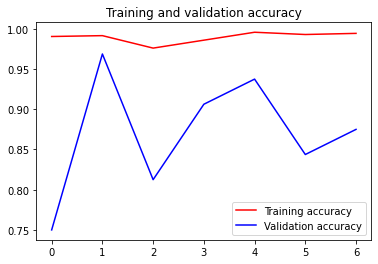

In [51]:
"""Funciones para graficar los history de validacion y el accuracy"""
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig("Training and validation accuracy - CNN-based TL.png")
plt.show()

In [52]:
"""Predicción del Modelo"""
y_pred = model.predict(x_test)

In [53]:
"""Mostrar el array del y_pred"""
y_pred.round()

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0.

In [54]:
"""Visualizar las métricas del modelo"""
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_pred.round(), y_test))

              precision    recall  f1-score   support

           0       0.92      0.73      0.82        49
           1       0.47      1.00      0.64        19
           2       1.00      0.79      0.88        57
           3       0.87      1.00      0.93        40
           4       0.87      0.74      0.80        35

   micro avg       0.83      0.83      0.83       200
   macro avg       0.83      0.85      0.81       200
weighted avg       0.88      0.83      0.84       200
 samples avg       0.83      0.83      0.83       200



In [55]:
"""Visualización del Accuracy"""
accuracy = model.evaluate(x_test,y_test,batch_size=32)
print("Accuracy: ",accuracy[1]*100)

7/7 [==============================] - 1s 72ms/step - loss: 1.0681 - acc: 0.8300
Accuracy:  82.99999833106995


In [56]:
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

In [57]:
"""Reporte de clasificación de las métricas"""
report = classification_report(Y_true, Y_pred_classes, target_names=categories)
print(report)

              precision    recall  f1-score   support

           e       0.73      0.92      0.82        39
           i       1.00      0.47      0.64        40
           a       0.79      1.00      0.88        45
           o       1.00      0.87      0.93        46
           u       0.74      0.87      0.80        30

    accuracy                           0.83       200
   macro avg       0.85      0.83      0.81       200
weighted avg       0.86      0.83      0.82       200



# Matriz de confusión

In [58]:
"""Estructurar la matriz de confusion"""
confusion = confusion_matrix(Y_true,Y_pred_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[36  0  3  0  0]
 [ 8 19  4  0  9]
 [ 0  0 45  0  0]
 [ 3  0  3 40  0]
 [ 2  0  2  0 26]]


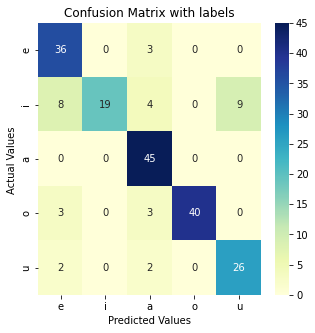

In [59]:
"""Librería para graficar la matriz de confusion"""
import seaborn as sns
plt.figure(figsize=(5, 5))

ma = sns.heatmap(confusion, cmap="YlGnBu", annot=True)
ma.set_title('Confusion Matrix with labels')
ma.set_xlabel('Predicted Values')
ma.set_ylabel('Actual Values ')
ma.xaxis.set_ticklabels(categories)
ma.yaxis.set_ticklabels(categories)

plt.show()

In [60]:
"""Crear un archivo de tipo json"""
model_json = model.to_json()
with open("CNN_TL_InceptionV3_Vocales_Classifier.json", "w") as json_file:
    json_file.write(model_json)
model.save("CNN_TL_InceptionV3_Vocales_Classifier.h5")
"""Guardar en el disco duro"""
print("Saved model to disk")
model.save_weights("CNN_TL_InceptionV3_Vocales.h5")

Saved model to disk
